## Init fast book

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.all import *

     |████████████████████████████████| 720 kB 5.0 MB/s 
     |████████████████████████████████| 189 kB 70.1 MB/s 
     |████████████████████████████████| 1.2 MB 55.2 MB/s 
     |████████████████████████████████| 46 kB 5.0 MB/s 
     |████████████████████████████████| 56 kB 6.4 MB/s 
     |████████████████████████████████| 51 kB 446 kB/s 
Mounted at /content/gdrive


In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('annotations'),Path('images')]

regex match

In [ ]:
fname=(path/'images').ls()[0]
fname, fname.name

(Path('images/basset_hound_124.jpg'), 'basset_hound_124.jpg')

In [ ]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['basset_hound']

## Pets Classification

Pets data argumentation

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/'images')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


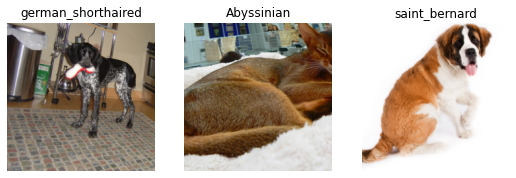

In [ ]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
pets.summary(path/'images')

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.492292,0.343487,0.117727,01:26


epoch,train_loss,valid_loss,error_rate,time
0,0.526600,0.297632,0.094723,01:18
1,0.317772,0.219975,0.076455,01:18


### Test manual data argumentation sequence

In [ ]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_y=parent_label,
                    item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()

In [ ]:
x.shape, y.shape

In [ ]:
x[0].shape

In [ ]:
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

## Cross-Entropy Loss

Soft Max

$$
\mathrm{softmax}(x_i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}
$$

In [ ]:
torch.random.manual_seed(42);
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Log Likelihood

$$
loss = -\log(\mathrm{softmax}(x_i))[targ]
$$

In [ ]:
targ = tensor([0,1,0,1,1,0])
idx = range(6)

sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
log_sm_acts = torch.log(sm_acts)
F.nll_loss(log_sm_acts, targ, reduction='none')

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

In [ ]:
loss_func = nn.CrossEntropyLoss()
loss_func(acts, targ)

tensor(1.8045)

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Improving Our Model
* Learning rate finder
* Frzee pretrained layer
* Discriminative Learning Rates

Learning rate finder

SuggestedLRs(valley=0.0010000000474974513)

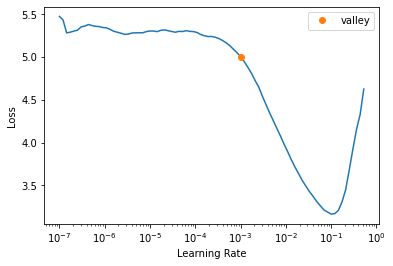

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
valley = learn.lr_find()
valley

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=0.003)

epoch,train_loss,valid_loss,error_rate,time
0,1.303786,0.290442,0.096076,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.539966,0.368365,0.114344,01:18
1,0.345778,0.246512,0.077131,01:17


freed pretrained

In [ ]:
learn.fine_tune??

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.freeze()
learn.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.285531,0.303862,0.106225,01:10
1,0.563408,0.234794,0.073072,01:11
2,0.354768,0.211447,0.065629,01:10


In [ ]:
learn.unfreeze()
learn.lr_find()